In [1]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from model import Generator, iterate_minibatches, compute_loss, train
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import time
import torch.utils.data

/opt/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
OCTAVE_NUM = 4
NOTE_NUM = 12
TIME_SCALE = 128


class LSTM_discriminator(nn.Module):
    def __init__(self,hidden_size = 1000,last_dim = 3):
        super(self.__class__, self).__init__()
        self.last_dim = last_dim
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*last_dim,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, last_dim)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*last_dim)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,self.last_dim)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*last_dim)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs
        
        
        

In [3]:
class LSTM_baseline(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data,_):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs

In [4]:
class BasicGenerator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3)

    def forward(self,data,_):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output
        

In [5]:
class BasicDiscriminator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,1)

    def forward(self,data):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data)
        return output

In [6]:
def g_loss(p_fake,sound,in_probs,p_baseline, eps = 1e-8):
    probs = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
            +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])
        
    return -((probs+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*(p_fake-p_baseline)).mean()

def d_loss(p_fake, p_true,eps = 1e-8):
    return -(1-p_fake+eps).log().mean()-(p_true+eps).log().mean()
    
def bl_loss(bl_pred,real_reward):
    return (bl_pred-real_reward).pow(2).mean()


In [8]:
import torch.utils.data

def sample_sound(data_gen):
    size = data_gen.size()
    rand = torch.rand(*size).cuda()
    sample = (rand<data_gen).type(torch.FloatTensor).cuda()
    sample[:,:,:,2] = 1
    return sample

In [9]:
from dataset import load_all
from constants import *

styles= [['data/Bach']]
train_data, train_labels = load_all(styles, BATCH_SIZE, TIME_SCALE)

In [10]:
X_tr = train_data[0][:]
y_tr = train_labels[0][:]
train_data[0].shape,

X_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.FloatTensor(X_tr),
            torch.FloatTensor(y_tr))),\
            batch_size=32,shuffle=True)

In [11]:
def train_discriminator(generator, discriminator,X_loader, num_epochs = 3,d_lr = 0.001, verbose = True):
    
    generator.eval()
    discriminator.train()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr,) #, weight_decay = 1, betas=(0.5, 0.999))  
    d_losses = []
    prob_noise = []
    prob_human = []
    prop_machine = []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, [x_batch,ch_batch] in enumerate(X_loader):
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()

            x_batch[:,:,:,2] = 1
            ch_batch[:,:,:,2] = 1

            # Optimize D  
 
            # rand_like ones_like
            noise_example = torch.cat([x_batch, sample_sound(torch.rand_like(x_batch).cuda())],dim = -1)
            true_example = torch.cat([x_batch, ch_batch],dim = -1)
            p_true_example = discriminator(true_example)
            p_noise_example = discriminator(noise_example)
            loss = d_loss(p_noise_example, p_true_example)
            d_optimizer.zero_grad()
            loss.backward()
            d_optimizer.step()
            d_losses.append(loss.data.cpu().numpy())
            
            prob_noise.append(p_noise_example.mean())
          
            
            # machine generation
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data          
            false_example = torch.cat([x_batch, sound],dim = -1)
            true_example = torch.cat([x_batch, ch_batch],dim = -1)
            p_true_example = discriminator(true_example)
            p_false_example = discriminator(false_example)
            loss = d_loss(p_false_example, p_true_example)
            d_optimizer.zero_grad()
            loss.backward()
            d_optimizer.step()
            d_losses.append(loss.data.cpu().numpy())
            
            prop_machine.append(p_false_example.mean().data.cpu().numpy())
            prob_human.append(p_true_example.mean().data.cpu().numpy())
        
#       # Visualize
        if verbose:
            display.clear_output(wait=True)
            plt.figure(figsize=(16, 6))

            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time)) 
            print('mean probability of human generation: {}'.format(prob_human[-1]))
#             print('mean probability of noise generation: {}'.format(prob_noise[-1]))
            print('mean probability of machine generation: {}'.format(prop_machine[-1]))
        
            plt.title("losses")
            plt.subplot(121)
            plt.plot(prob_human,label = "probability of human generation")
            plt.plot(prop_machine,label = "probability of machine generation")
            plt.legend()
            plt.subplot(122)
            plt.plot(d_losses,label = "Discriminator loss")
            plt.legend()
            plt.show()
            
    return discriminator,np.array(prob_human),np.array(prop_machine),np.array(d_losses)

In [12]:
def train_generator(generator,discriminator,baseline, X_loader,num_epochs = 3,g_lr = 0.001, verbose=True):
    
    generator.train()
    discriminator.train()
    baseline.train()
    g_optimizer = torch.optim.Adam(generator.parameters(),  lr=g_lr)#, betas=(0.5, 0.999))

    g_losses = []
    prop_machine = []
    prob_human = []
    prob_confidence = []
    prob_noise = []
    
#     generator_baseline = Generator().cuda()
#     generator_baseline.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
    
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, [x_batch,ch_batch] in enumerate(X_loader):
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()

            x_batch[:,:,:,2] = 1
            ch_batch[:,:,:,2] = 1
          
            #generator
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data                 
            false_example = torch.cat([x_batch, sound],dim = -1)
            true_example = torch.cat([x_batch, ch_batch],dim = -1)
            p_true_example = discriminator(true_example.detach())
            p_false_example = discriminator(false_example.detach())
            
            p_baseline = baseline(x_batch,ch_batch)
            
            # history
            prob_human.append(p_true_example.mean().data.cpu().numpy())
            prop_machine.append(p_false_example.mean().data.cpu().numpy())
            prob_confidence.append(data_gen.mean().data.cpu().numpy())
            
            # Optimize G  
#             data_gen = generator_baseline(x_batch,ch_batch)
#             sound = sample_sound(data_gen).data                 
#             false_example = torch.cat([x_batch, sound],dim = -1)
#             p_baseline = discriminator(false_example.detach())
            
            loss = g_loss(p_false_example, sound, data_gen, p_baseline)+compute_loss(data_gen, ch_batch)
                 
            loss.backward()
            g_optimizer.step()
            g_optimizer.zero_grad()
            g_losses.append(loss.data.cpu().numpy())
        
        # Visualize
        if verbose:
            display.clear_output(wait=True)
            plt.figure(figsize=(16, 6))

            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time)) 
            print('mean probability of human generation: {}'.format(prob_human[-1]))
            print('mean probability of machine generation: {}'.format(prop_machine[-1]))
    #         print('mean probability of noise generation: {}'.format(prob_noise[-1]))
            print('mean probability of machine generation confidence: {}'.format(prob_confidence[-1]))


            plt.title("losses")
            plt.subplot(131)
            plt.plot(prob_human,label = "Human probability")
            plt.plot(prop_machine,label = "Machine probability")
            plt.legend()
            plt.subplot(132)
            plt.plot(g_losses,label = "Generator loss")
            plt.legend()
            plt.subplot(133)
            plt.plot(prob_confidence,label = "Machine confidence")
            plt.legend()
            plt.show()

            
    return generator, np.array(prob_human),np.array(prop_machine), np.array(prob_confidence), np.array(g_losses)

In [13]:
def train_baseline(generator, discriminator, baseline, X_loader,num_epochs = 3, b_lr = 0.001, verbose=True):
    
    discriminator.train()
    generator.train()
    bl_optimizer = torch.optim.Adam(generator.parameters(),  lr=b_lr)
    
    bl_losses = []
    prob_baseline = [] 
    
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, [x_batch,ch_batch] in enumerate(X_loader):
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()

            x_batch[:,:,:,2] = 1
            ch_batch[:,:,:,2] = 1
            
            # Optimize BL
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen).data
            false_example = torch.cat([sound,x_batch],dim = -1)
            p_baseline = baseline(x_batch,ch_batch)
            p_false_example = discriminator(false_example)
            loss = bl_loss(p_baseline, p_false_example)
            bl_optimizer.zero_grad()
            loss.backward()
            bl_optimizer.step()
            
            # history
            bl_losses.append(loss.data.cpu().numpy())
            prob_baseline.append(p_baseline.mean().data.cpu().numpy())

            
    return baseline, np.array(prob_baseline),np.array(bl_losses)

In [14]:
# discriminator = LSTM_discriminator(hidden_size=100, last_dim=6).cuda()
# generator = Generator().cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))

In [15]:
# # generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
# pretrained_discriminator, prob_human, prop_machine, d_losses = train_discriminator(generator, discriminator,X_loader, X_loader2,
#                                                                         num_epochs = 30, d_lr=1e-3)

In [16]:
# torch.save(pretrained_discriminator.state_dict(), os.path.join(OUT_DIR, 'pretrained_discriminator'))

In [17]:
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
# baseline = LSTM_baseline(hidden_size=10).cuda()
# generator,prob_human, prop_machine, prob_confidence, g_losses= train_generator(generator, discriminator, baseline, X_loader, num_epochs = 30, g_lr=1e-3)

In [18]:
def train_GAN(generator,discriminator,baseline,X_loader,g_lr = 0.001, d_lr = 0.001, bl_lr = 0.001):
    
    history = {'d_losses':[],'g_losses':[],'bl_losses':[],'prop_machine':[],
               'prob_human':[],'prob_confidence':[1,],'prop_baseline':[], 'prob_noise':[], 'color':[]}
    
    num_iteration = 0
    max_iteration = 100
    
    p_human = np.array([1])
    p_machine = np.array([0])
    
    while num_iteration<max_iteration:
        start_time = time.time()
        num_iteration+=1
        
        baseline, p_baseline, bl_l = train_baseline(generator, discriminator, baseline, 
                                                    X_loader,num_epochs = 1,b_lr = 0.001, verbose=False)
        history['prop_baseline'].extend(p_baseline)
        history['bl_losses'].extend(bl_l) 
        
        if np.maximum(p_human-p_machine,0).mean()<0.1:
            discriminator, p_human, p_machine, d_l = \
                                train_discriminator(generator, discriminator,X_loader, 
                                                            num_epochs = 1, d_lr=d_lr, verbose = False)
            history['d_losses'].extend(d_l)
            history['prop_machine'].extend(p_machine)
            history['prob_human'].extend(p_human)
            history['color'].extend(np.ones(d_l.shape[0]))
        else: 
            
            generator, p_human, p_machine, p_confidence, g_l = \
                                train_generator(generator, discriminator, baseline, X_loader,
                                                            num_epochs = 1, g_lr=g_lr, verbose = False)
            history['g_losses'].extend(g_l)
            history['prop_machine'].extend(p_machine)
            history['prob_human'].extend(p_human)  
            history['prob_confidence'].extend(p_confidence)
            history['color'].extend(0*np.ones(g_l.shape[0]))
        
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(16, 6))

        # Then we print the results for this epoch:
        if history['color'][-1]==0:
            tr = 'generator trainig'
        else: tr = 'discriminator trainig'
        print("Epoch {} of {} took {:.3f}s, format {}".format(
            num_iteration, max_iteration, time.time() - start_time, tr))
        print('mean probability of machine generation: {}'.format(history['prop_machine'][-1]))
        print('mean probability of human generation: {}'.format(history['prob_human'][-1]))
    #         print('mean probability of noise generation: {}'.format(prob_noise[-1]))
        print('mean probability of machine generation confidence: {}'.format(history['prob_confidence'][-1]))


        plt.title("losses")

        plt.subplot(231)
        plt.plot(history['g_losses'],label = "Generator loss")
        plt.legend()
        plt.subplot(232)
        plt.plot(history['d_losses'],label = "Discriminator loss")
        plt.legend(loc=2)
        plt.subplot(233)
        plt.plot(history['bl_losses'],label = "Baseline loss")
        plt.legend()
        plt.subplot(234)
        plt.plot(history['prop_machine'],label = "Machine probability")
        plt.plot(history['prob_human'],label = "Human probability")
        plt.legend()
        plt.subplot(235)
        plt.plot(history['prob_confidence'],label = "Machine confidence")
        plt.legend()
        plt.subplot(236)
        plt.plot(history['prob_confidence'],label = "Baseline probabilyty")
        plt.legend()
        plt.show()

            
    return generator,discriminator,baseline, history

In [19]:
discriminator = LSTM_discriminator(hidden_size=100, last_dim=6).cuda()
generator = Generator().cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
baseline = LSTM_baseline(hidden_size=10).cuda()
# generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))
generator.load_state_dict(torch.load(os.path.join(OUT_DIR, 'generator_rl')))

Epoch 5 of 100 took 242.738s, format generator trainig
mean probability of machine generation: 0.7290786504745483
mean probability of human generation: 0.9812647104263306
mean probability of machine generation confidence: 0.3514358103275299


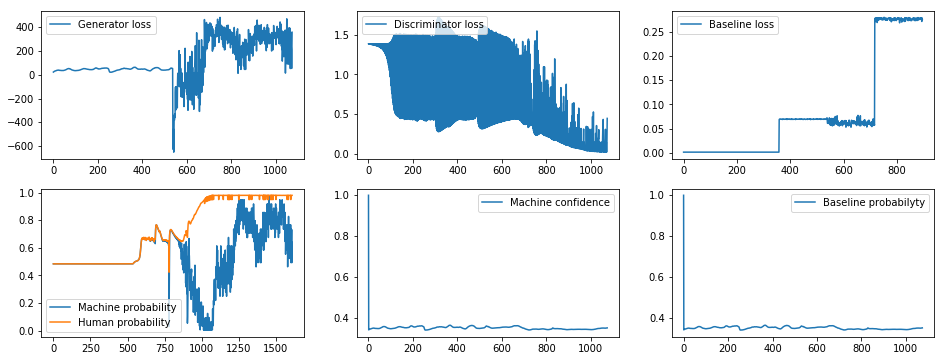

In [ ]:
generator,discriminator,baseline,history =\
                    train_GAN(generator,discriminator,baseline,\
                            X_loader, g_lr = 1e-4,d_lr=1e-4, bl_lr = 1e-2)

In [ ]:
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'generator_rl'))

In [ ]:
from generate import write_file, generate
# import gc
# torch.cuda.empty_cache()
# gc.collect() 

# with torch.cuda.device(GPU):
write_file('output/rl_test', generate(generator, 8))